Longstaff-Schwartz

In [1]:
import numpy as np

In [107]:
## GBM simulation

def sim_gbm(t, x0, M, N, mu, sigma, seed=None):
    """
    Function for simulating Geometric Brownian Motion over specified time steps and initial values of the processes.
    The simulation uses the discretized analytical solution,
        X(t+1) = X(t) * exp{(mu-0.5*sigma^2)*dt + sigma * W(t)}
    :param t:       time steps (including start and endpoints)
    :param x0:      Initial values of the processes
    :param M:       Number of discretizations (time steps)
    :param N:       Number of simulations
    :param mu:      Drift coefficient
    :param sigma:   Diffusion coefficient (volatility)
    :param seed:    Seed used for replication of results
    :return:        numpy.array with dim (M+1, N).
                    Rows are time steps (including the start and end-point)
                    Columns are the number of simulations
    """

    if not len(t) == M+1:
        raise ValueError('Length of time steps must include both start and endpoint, that is have length of M+1.')

    rng = np.random.default_rng(seed=seed)
    Z = rng.standard_normal(size=(M, N))

    x = np.zeros(shape=(M + 1, N))
    x[0] = x0 * np.ones(shape=(1, N))

    for j in range(len(t[1:])):
        dt = t[j+1] - t[j]
        x[j+1] = x[j] * np.exp((mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z[j])

    return x


if __name__ == '__main__':
    # Parameters
    t0 = 0.0
    T = 3.0
    x0 = [50, 100, 50, 100, 50]
    M = 10
    N = 5
    mu = 0.07
    sigma = 0.2
    seed = None

    # Equidistant time steps
    t = np.linspace(start=t0, stop=T, num=M+1, endpoint=True)

    # Perform simulation
    x = sim_gbm(t=t, x0=x0, M=M, N=N, mu=mu, sigma=sigma, seed=seed)
    print(x)

[[ 50.         100.          50.         100.          50.        ]
 [ 49.76494302 125.31406238  55.8702751   75.21611135  51.38613777]
 [ 46.97982024 120.05877002  50.5540588   73.35933489  47.87984483]
 [ 48.25437095 145.023348    53.57459112  75.91271569  44.94211508]
 [ 47.46796986 141.53465401  58.27595599  78.98407757  46.1094956 ]
 [ 48.69180935 140.18709691  57.81854909  79.42058291  51.7793691 ]
 [ 57.31915594 153.25927926  75.68059702  81.85938993  45.40125564]
 [ 58.48834293 168.51966686  89.04956439  90.31363706  47.58893254]
 [ 46.88542354 160.10694149  95.83161079  75.13157498  47.92082004]
 [ 49.87424017 130.84133891 104.38062135  83.22160082  46.59819856]
 [ 54.49624247 125.42930227 105.46436253  82.50497244  49.57839466]]


In [108]:
## payoff func
def put_payof(S, K):
    return np.maximum(K-S, 0)

def call_payof(S, K):
    return np.maximum(S-K,0)

In [254]:
## LSMC implementation
def LSMC_regression(S, K, r, sigma, T, M, N, payoff_func):
    dt = T/M ## timesteps
    df = np.exp(-r*dt) ## discount factor
    

    payoff_mat = np.zeros((M+1, N)) ## initialize option value matrix
    stopping_rule = np.empty((M+1, N))

    # Set the final option values to the payoff
    payoff_mat[-1, :] = payoff_func(S[-1, :], K)

    # Perform LSMC regression backwards through time
    for t in range(M - 1, 0, -1):
        # Select in-the-money stock prices and corresponding option values
        S_t = S[t, :]
        payoff_t = payoff_mat[t+1, :]
        in_the_money = (S_t < K) ## true/false

        # Fit a polynomial to the in-the-money option values
        #fitted = np.polyfit(S_t[in_the_money], option_t[in_the_money] * df, 2)
        coeff =  np.polyfit(S_t[in_the_money], payoff_t[in_the_money], 2) # number of powers * df

        # Compute the continuation value at each stock price
        continuation_value =  np.polyval(coeff, S_t) # *df  #fitted(S_t[in_the_money])


        # Update the option value matrix using the exercise rule
        early_exercise = payoff_func(S_t, K)
        early_exercise[in_the_money] = np.maximum(early_exercise[in_the_money], continuation_value[in_the_money])
        stopping_rule[t, :] = in_the_money
        payoff_mat[t, :] = early_exercise

    # Compute the estimated option price

    stopping_rule = (np.cumsum(np.cumsum(stopping_rule, axis=0), axis=0) == 1).astype(int)
    #estimated_price = 

    #estimated_price = np.sum(payoff_mat[1, :]) / N * np.exp(-r*T)


    return stopping_rule


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


[]

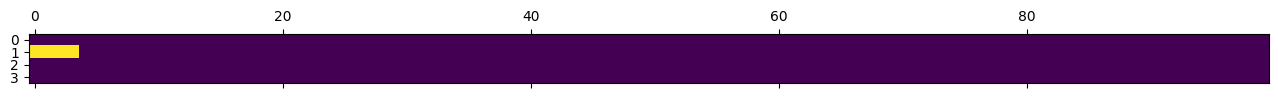

In [265]:
from matplotlib import pyplot as plt
M = 3
N = 100
K = 100  # strike price
r = 0.00
sigma = 0.2
T = 1

t = np.linspace(start=t0, stop=T, num=M+1, endpoint=True)

seed = None #12345
S_mat = sim_gbm(t=t, x0=100, M=M, N=N, mu=r, sigma=sigma, seed=seed)


Y = LSMC_regression(S_mat, K, r, sigma, T, M, N, put_payof)

print(Y)
plt.matshow(Y)
plt.plot()

In [105]:
rnd = np.random.RandomState(1234)
x = S_mat

# Payoff (exercise) function
strike = 0.95

def put_payoff(spot):
    return np.maximum(strike - spot, 0.0)

# Discount factor function
def constant_rate_df(t_from, t_to):
    return np.exp(-r * (t_to - t_from))

# Approximation of continuation value
def fit_quadratic(x, y):
    return np.polynomial.Polynomial.fit(x, y, 2, rcond=None)

# Selection of paths to consider for exercise
# (and continuation value approxmation)
def itm(payoff, spot):
    return payoff > 0

# Run valuation of American put option
npv_american = longstaff_schwartz(x, t, constant_rate_df,
                                  fit_quadratic, put_payoff, itm)

# European put option for comparison
npv_european = constant_rate_df(t[0], t[-1]) * put_payoff(x[-1]).mean()

# Check results
assert np.round(npv_american, 4) == 0.0734
assert np.round(npv_european, 4) == 0.0626
assert npv_american > npv_european

ValueError: Coefficient array is empty

In [203]:



T = 1
dt = T/M2

t = np.linspace(start=t0, stop=T, num=M2+1, endpoint=True)

#S_mat = sim_gbm(t=t, x0=100, M=M2, N=N2, mu=r, sigma=sigma, seed=seed)

S_mat2 = np.array([[1, 1, 1,1,1,1,1,1],
[1.09, 1.16, 1.22, 0.93, 1.11, 0.76, 0.92, 0.88], 
[1.08, 1.26, 1.07, 0.97, 1.56, 0.77, 0.84, 1.22], 
[1.34, 1.54, 1.03, 0.92, 1.52, 0.9, 1.01, 1.34]])

print(np.shape(S_mat2.T))

def LSMC_regression2(S, K, r, T, M, N, payoff_func):
    dt = T/M ## timesteps
    df = np.exp(-r*dt) ## discount factor
    

    option_mat = np.zeros((M+1, N)) ## initialize option value matrix

    # Set the final option values to the payoff
    option_mat[-1, :] = payoff_func(S[-1, :], K)

    # Perform LSMC regression backwards through time
    for t in range(M-1, 0, -1):
        # Select in-the-money stock prices and corresponding option values
        S_t = S[t, :]
        option_t = option_mat[t, :]
        print("S(t)", S_t)
        in_the_money = (S_t < K) ## true/false for PUT
        print(in_the_money)

        # Fit a polynomial to the in-the-money option values
        coeff = np.polyfit(S_t[in_the_money], option_t[in_the_money], 2) # number of powers

        # Compute the continuation value at each stock price
        continuation_value = np.polyval(coeff, S_t) * df

        # Update the option value matrix using the exercise rule
        early_exercise = payoff_func(S_t, K)
        print("early_exercise", early_exercise[in_the_money])
        print("continuation_value", continuation_value[in_the_money])
        early_exercise[in_the_money] = np.maximum(early_exercise[in_the_money], continuation_value[in_the_money])
        #print("max", early_exercise)
        #print("max itm", early_exercise[in_the_money])
        option_mat[t, :] = early_exercise
        print(option_mat)

    # Compute the estimated option price
    estimated_price = np.sum(option_mat[1, :]) / N

    return estimated_price

LSMC_regression2(S=S_mat2, K=1.1, r=0.06, T=1, M=4, N=8, payoff_func=put_payof)

(8, 4)
S(t) [1.34 1.54 1.03 0.92 1.52 0.9  1.01 1.34]
[False False  True  True False  True  True False]
early_exercise [0.07 0.18 0.2  0.09]
continuation_value [0. 0. 0. 0.]
[[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.07 0.18 0.   0.2  0.09 0.  ]
 [0.   0.   0.07 0.18 0.   0.2  0.09 0.  ]]
S(t) [1.08 1.26 1.07 0.97 1.56 0.77 0.84 1.22]
[ True False  True  True False  True  True False]
early_exercise [0.02 0.03 0.13 0.33 0.26]
continuation_value [0. 0. 0. 0. 0.]
[[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.   0.03 0.13 0.   0.33 0.26 0.  ]
 [0.   0.   0.07 0.18 0.   0.2  0.09 0.  ]
 [0.   0.   0.07 0.18 0.   0.2  0.09 0.  ]]
S(t) [1.09 1.16 1.22 0.93 1.11 0.76 0.92 0.88]
[ True False False  True False  True  True  True]
early_exercise [0.01 0.17 0.34 0.18 0.22]
continuation_value [0. 0. 0. 0. 0.]
[[0.   0.   0.   0.   0.   0.   0.   0.  ]
 

0.11500000000000003

In [ ]:
from longstaff_schwartz.algorithm import longstaff_schwartz
from longstaff_schwartz.stochastic_process import GeometricBrownianMotion
import numpy as np

# Model parameters
t = np.linspace(0, 5, 100)  # timegrid for simulation
r = 0.01  # riskless rate
sigma = 0.15  # annual volatility of underlying
n = 100  # number of simulated paths

# Simulate the underlying
gbm = GeometricBrownianMotion(mu=r, sigma=sigma)
rnd = np.random.RandomState(1234)
x = gbm.simulate(t, n, rnd)  # x.shape == (t.size, n)

# Payoff (exercise) function
strike = 0.95

def put_payoff(spot):
    return np.maximum(strike - spot, 0.0)

# Discount factor function
def constant_rate_df(t_from, t_to):
    return np.exp(-r * (t_to - t_from))

# Approximation of continuation value
def fit_quadratic(x, y):
    return np.polynomial.Polynomial.fit(x, y, 2, rcond=None)

# Selection of paths to consider for exercise
# (and continuation value approxmation)
def itm(payoff, spot):
    return payoff > 0

# Run valuation of American put option
npv_american = longstaff_schwartz(x, t, constant_rate_df,
                                  fit_quadratic, put_payoff, itm)

# European put option for comparison
npv_european = constant_rate_df(t[0], t[-1]) * put_payoff(x[-1]).mean()

# Check results
assert np.round(npv_american, 4) == 0.0734
assert np.round(npv_european, 4) == 0.0626
assert npv_american > npv_european

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5988ebf3-11a3-41bf-845d-5372bcc3f315' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>